# A guide to using the HoloFood Data Portal
This tutorial showcases the core uses of the Data Portal.
There is a solution to each learning objective.

## Objective 1: Finding samples using the website

Open the [HoloFood Data Portal]({{< var portal.root_url >}}).

Find all *Salmon* Fatty Acids samples from fish that were treated with Fermented Algae.

:::{.callout-tip collapse="true"}
### Solution

- Click `Salmon samples` in the navigation bar.
- Type `fermented algae` into the `Treatment Search` filter next to the table, select `fatty_acids` in the `Sample type` filter, and press `Apply`.
:::

## Objective 2: Find animal metadata for a specific sample

- Find the *Chicken* sample `SAMEA7025251`.
- From the sample's host-animal metadata, find the average daily feed intake of chicken's in that pen in the first trial week.

:::{.callout-tip collapse="true"}
### Solution
- Search for `SAMEA7025251` in the main search box at the top of every page.
- From the sample's detail page, follow the link to the sample's host animal `SAMEA112905290`
- Open the `Animal metadata` section of the animal detail page.
- Switch to the `Pen` tab of metadata.
- Find the `Average Daily Feed intake: Day 00 - 07` row (measurement = 18.59g).
:::

## Objective 3: Find functional information for a sample in MGnify

- Find chicken sample `SAMEA7817177` on the data portal
- Follow the links to the sample's metagenomics analyses on MGnify
- What is `SAMEA7817177`'s top Pfam entry (from MGnify's functional analysis of it)?

:::{.callout-tip collapse="true"}
### Solution

- Type `SAMEA7817177` into the `Search data and docs` search bar at the top of the data portal
- The sample detail page for `SAMEA7817177` will open directly
- Open the `Metagenomics` section of the sample detail page.
- Click the assembly analysis in the table
- On MGnify, switch to the `Functional analysis` tab.
- Find the `Pfam` subtab
- Find the first row of the table (the biggest bar in the bar chart)
- It is `Reverse transcriptase` [PF07727](https://pfam.xfam.org/family/PF07727)
:::

## Objective 4: Find MAG metadata from MGnify

- Find the `HoloFood Chicken Gut v1` genome `MGYG000308389`
- Using the genome's species representative, find the genome's most prevalent [COG category](https://www.ncbi.nlm.nih.gov/research/cog) with a known function.

:::{.callout-tip collapse="true"}
### Solution

- Click `Genomes` in the navigation bar.
- Select the `HoloFood Chicken Gut v1` catalogue in the sub navigation
- Type `MGYG000308389` in the `Accession contains` filter.
    - *You could also jump straight to here by entering the accession in the global search box*
- Click `View on MGnify` in the single row of the table.
- On the MGnify page that opens, switch to the `COG analysis` sub-tab.
- Look at the bar chart. Ignoring cataegory `S (Function unknown)`, category `K (Transcription)` is the most prevalent COG category in this genome.
:::

## Objective 5: Find viral fragments within a MAG

:::{.callout-caution}
### Data coming soon
Viral catalogues are not yet available for HoloFood, however viral annotations are available for the genomes in MGnify.
:::


## Objective 6: Compare metadata between samples, using TSV files in a Spreadsheet

- Find chicken animal `SAMEA112905066` on the data portal, and download the sample's metadata TSV file
- Do the same for animal `SAMEA112904813`
- Notice that these samples are chickens in different pens, fed different diets (`Control`, and `Probiotic`respectively)
- Pick a spreadsheet application like [Google Sheets](https://sheets.google.com), Excel, or LibreOffice Calc, (or write some code)
- Make a plot comparing the average weight gain of chickens in each of the two pens over time

:::{.callout-tip collapse="true"}
### Solution

- Open the `Chicken samples` navigation item
- Type `SAMEA14099422` into the `Accession contains` filter and press `Apply`
- Click `View` in the only row in the table
- Scroll down and open the `Sample metadata` section
- Press `Download all as TSV`
- Rename the downloaded file (`metadata.tsv`) to something useful like `control.tsv`
- Repeat the previous steps for `SAMEA7025235`, getting to a file called e.g. `probiotic.tsv`
- Open/import both files in your spreadsheet application
- Find the rows labelled `Average body weight at day 00.....35`
- Copy and paste the rows from each sheet next to each other
- In Google Sheets, press `Insert > Chart` (or similar in other applications)

![Screenshot of spreadsheet chart comparing average weight of chickens in two pens fed Control and Probiotic diets respectively](img/tutorial/weight-chart.png)

:::

## Objective 7: Use Python to analyse data from the API

:::{.callout-note}
### Coding required
This objective takes a lot longer than the others – it involves coding and the API.
:::

:::{.callout-tip}
### Packages required
```bash
pip install requests pandas matplotlib
```
:::

- Use the [API]({{< var portal.root_url >}}/api) to fetch a list of HoloFood salmon samples as a Pandas dataframe (the [API docs will be very helpful](api.ipynb#from-python))
    - Only fetch salmon samples which were taken for Iodine measurements
    - Only fetch salmon samples from tanks SD02 and SD04, which are tanks with treatment of 0.0% and 2.0% concentration seaweed treatment
    - Only fetch samples which have a non-empty value for metadata variable `Iodine` (that's the measurement of iodine in the fish feces)
- Use the API to fetch sample and animal metadata for each sample and add it to the Pandas dataframe
- Make a histogram of the iodine measurements, grouped by the treatment concentration

Here's a startpoint for the libraries and base API endpoint you need:

In [21]:
samples_endpoint_base = 'https://www.holofooddata.org/api/samples'
animals_endpoint_base = 'https://www.holofooddata.org/api/animals'
import requests
import pandas as pd
import matplotlib.pyplot as plt

A complete solution is below.

Fetching page = 1 of tank = 'SD02'
Fetching page = 1 of tank = 'SD04'


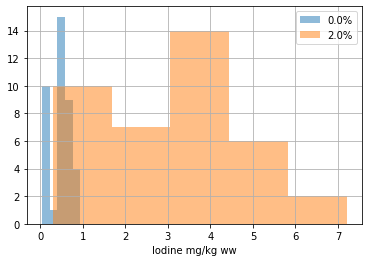

In [81]:
#|code-fold: true
samples_df = None

# Fetch samples
for tank in ['SD02', 'SD04']:
    page = 1
    while page:
        print(f'Fetching {page = } of {tank = }')
        samples_page = requests.get(
            f'{samples_endpoint_base}?{page=}&system=salmon&sample_type=iodine&require_metadata_value=Iodine&title={tank}'
        ).json()
        samples_page_df = pd.json_normalize(
            samples_page['items']
        )

        if samples_df is None:
            samples_df = samples_page_df
        else:
            samples_df = pd.concat(
                [
                    samples_df,
                    samples_page_df
                ]
            )

        page += 1
        if len(samples_df) >= samples_page['count']:
            page = False

def get_iodine_and_sample_time(sample):
    """Fetch metadata for the sample and its host animal."""
    sample_detail = requests.get(
        f'{samples_endpoint_base}/{sample.accession}'
    ).json()
    metadata = sample_detail['structured_metadata']
    iodine = next(
        metadatum 
        for metadatum in metadata 
        if metadatum['marker']['name'] == 'Iodine'
    )

    animal_detail = requests.get(
        f'{animals_endpoint_base}/{sample.animal}'
    ).json()
    metadata = animal_detail['structured_metadata']
    timepoint = next(
        metadatum
        for metadatum in metadata
        if metadatum['marker']['name'] == 'Sampling time'
    )
    treatment_concentration = next(
        metadatum
        for metadatum in metadata
        if metadatum['marker']['name'] == 'Treatment concentration'
    )
    
    iodine_measurement = iodine['measurement']
    iodine_clean = iodine_measurement.replace(',', '.')
    try:
        iodine_float = float(iodine_clean)
    except ValueError:
        iodine_float = pd.NA
    
    return iodine_float, timepoint['measurement'], treatment_concentration['measurement']

# Consolidate the metadata with the samples
metadata = samples_df.apply(
    get_iodine_and_sample_time, 
    axis='columns', 
    result_type='expand'
).rename(
    columns={
        0: 'iodine_mg_kg_ww', 
        1: 'sampling_timepoint',
        2: 'treatment_concentration'
    }
)
trial_samples = pd.concat(
    [
        samples_df,
        metadata
    ],
    axis=1
)

# Drop the Day 0 samples
not_pretrial_control = trial_samples[trial_samples.sampling_timepoint != 'Day 0']

# Plot iodine measurements
not_pretrial_control.groupby('treatment_concentration').iodine_mg_kg_ww.hist(legend=True, bins=5, alpha=0.5)
plt.xlabel('Iodine mg/kg ww');